In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
# import data from CA, CT, TX, FL, NY, NJ 
ca = pd.read_csv('data/ca_ev_registrations_public.csv')
nj = pd.read_csv('data/nj_ev_registrations_public.csv')
ny = pd.read_csv('data/ny_ev_registrations_public.csv')
tx = pd.read_csv('data/tx_ev_registrations_public.csv')
fl = pd.read_csv('data/fl_ev_registrations_public.csv')
ct = pd.read_csv('data/ct_ev_registrations_public.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# ca.info()
# # 2542443 entries in CA
# nj.info()
# # NJ has 309872 entries
# ny.info()
# tx.info()
# ct.info()
# fl.info()
# # ca['Registration Valid Date'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542443 entries, 0 to 2542442
Data columns (total 9 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Vehicle ID                    object 
 1   County GEOID                  object 
 2   Registration Valid Date       object 
 3   DMV ID                        int64  
 4   DMV Snapshot                  object 
 5   Registration Expiration Date  float64
 6   State Abbreviation            object 
 7   Geography                     object 
 8   Vehicle Name                  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 174.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309872 entries, 0 to 309871
Data columns (total 10 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DMV ID                        309872 non-null  int64  
 1   DMV Snapshot (Date)           309872 non-null  object 


In [22]:
# Create Data frame with years and amount of registered vehicles in that year
ca_years = pd.DataFrame(ca['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])
ca_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Year                 11 non-null     object
 1   Registered Vehicles  11 non-null     object
dtypes: object(2)
memory usage: 304.0+ bytes


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11 entries, 2020-01-01 to 2010-01-01
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Registered Vehicles  11 non-null     object
dtypes: object(1)
memory usage: 176.0+ bytes


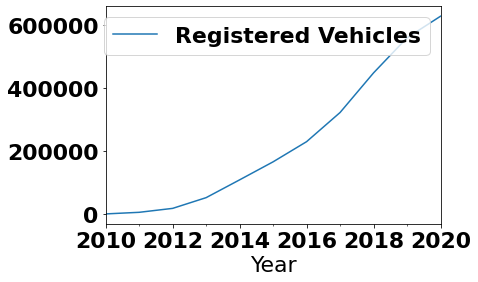

In [78]:
# As we can see, data is not stationary. 
ca_df = pd.DataFrame(ca_years['Registered Vehicles'])
ca_df = ca_df.set_axis(pd.to_datetime(ca_years['Year']))
ca_df.plot()
ca_df.info()
ca_df = ca_df.sort_values(by=['Registered Vehicles'], ascending = True)

In [7]:
catest = adfuller(ca_df)
display(catest)
# Pvalue - 0.41624347392997485

(-1.7289856139173432,
 0.41624347392997485,
 3,
 7,
 {'1%': -4.9386902332361515,
  '5%': -3.477582857142857,
  '10%': -2.8438679591836733},
 138.47165121551794)

In [87]:
ca_df = ca_df.astype(float)
ca_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11 entries, 2010-01-01 to 2020-01-01
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Registered Vehicles  11 non-null     float64
dtypes: float64(1)
memory usage: 176.0 bytes


In [90]:
catrain = ca_df[:9]
catest = ca_df[9:]
combined = ca_df
catrain.shape


(9, 1)

In [92]:
auto_modelca = pm.auto_arima(catrain, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_modelca.summary())

# (1,0,0), (0,0,0) , [0]

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=248.220, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=249.333, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=243.836, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=233.823, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=240.827, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.614 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    9
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -113.911
Date:        

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4128      0.082     17.205      0.000       1.252       1.574
sigma2      2.844e+08   3.15e-11   9.01e+18      0.000    2.84e+08    2.84e+08


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


ValueError: could not broadcast input array from shape (9,) into shape (11,)

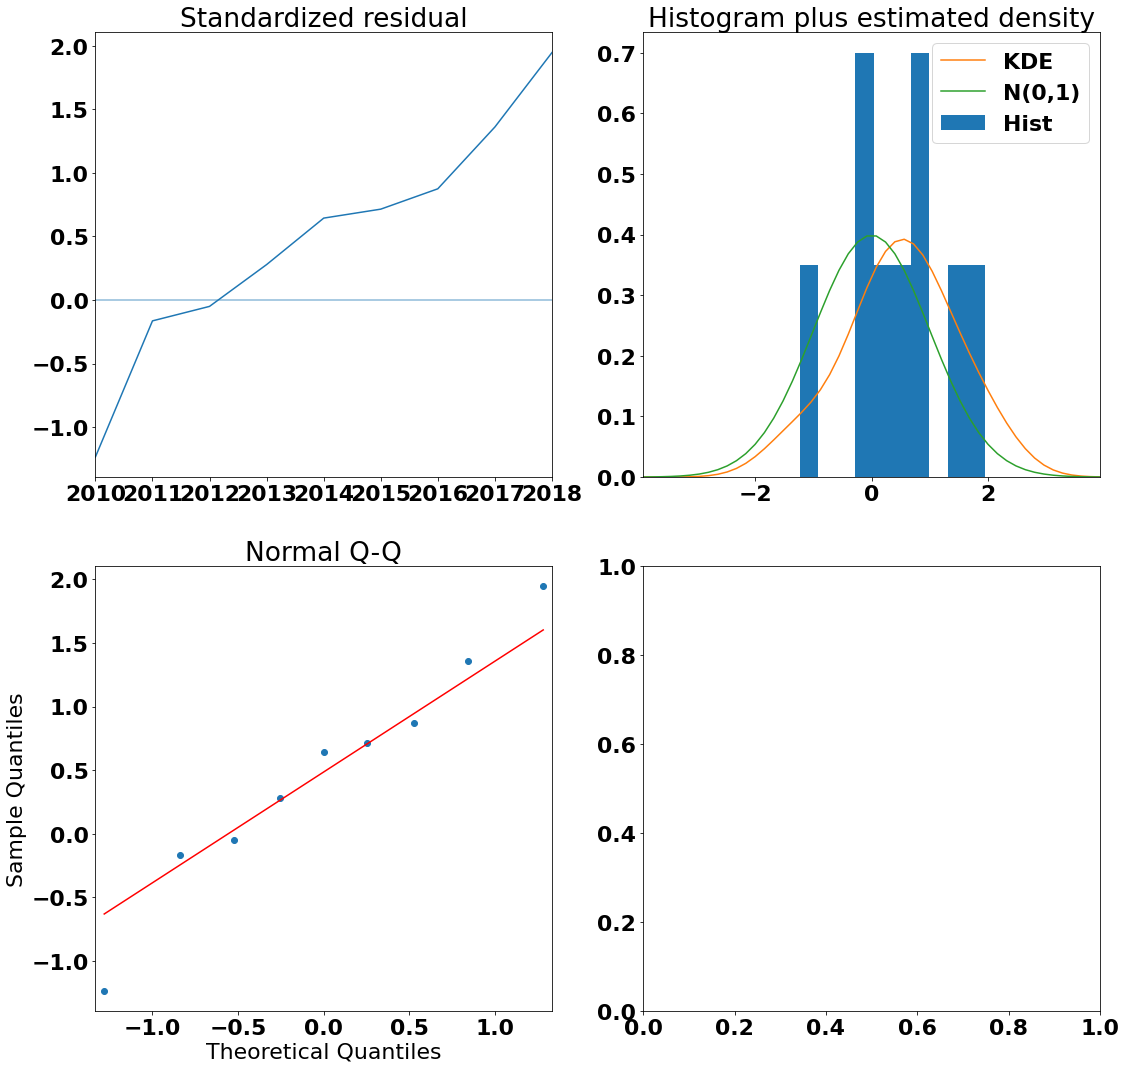

In [91]:
ARIMA_MODELCA = sm.tsa.statespace.sarimax.SARIMAX(catrain, 
                                        order=(1,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


outputca = ARIMA_MODELCA.fit()

print(outputca.summary().tables[1])
auto_modelca.plot_diagnostics(figsize=(18,18))
plt.show()

In [97]:
predca = outputca.get_prediction(start=pd.to_datetime('2018-01-01'), end=pd.to_datetime('2020-01-01'), dynamic=False)
pred_confca = predca.conf_int()
pred_confca

,lower Registered Vehicles,upper Registered Vehicles
2018-01-01,422936.531481,489038.308669
2019-01-01,600669.651807,666771.428995
2020-01-01,838092.523743,952506.086168


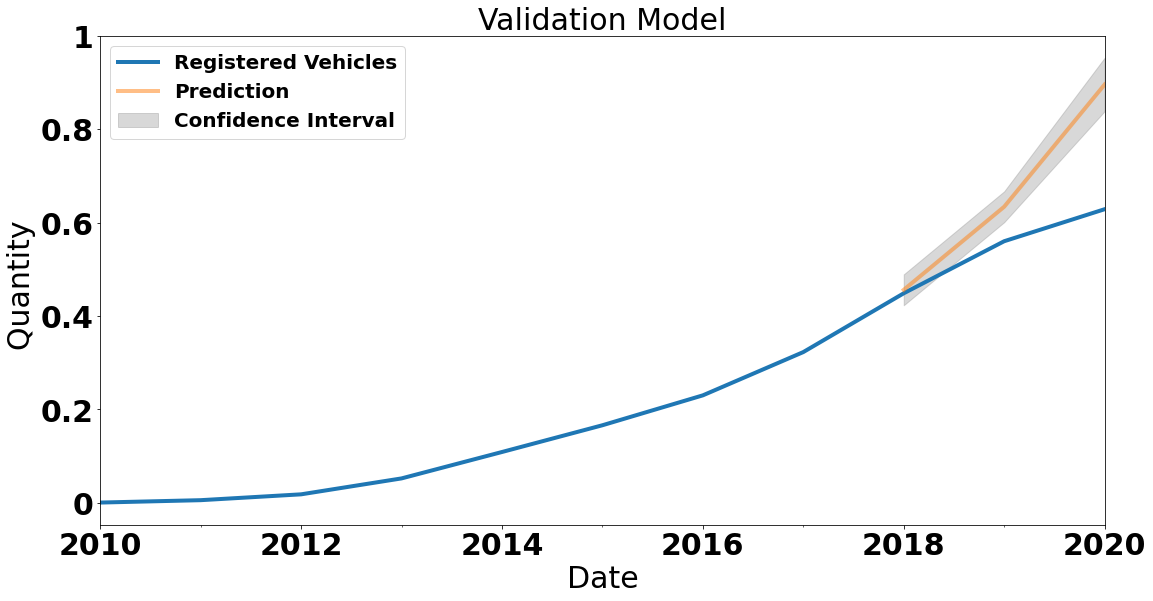

In [98]:


rcParams['figure.figsize'] = 18, 9
ax = ca_df.plot(label='observed', linewidth = 4)

predca.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_confca.index,
                pred_confca.iloc[:, 0],
                pred_confca.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity ',fontsize=30)
plt.yticks(fontsize=30)
#Changing the y scale to ($) Millions
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

In [15]:

# ca_df.head()

Year
2020-01-01    628473.0
2019-01-01    559969.0
2018-01-01    448567.0
2017-01-01    322762.0
2016-01-01    230171.0
Name: Registered Vehicles, dtype: float64

In [ ]:
# Differencing to be stationary 
# ca_diff = ca_df.diff().dropna()
# ca_diff.plot()

In [ ]:
cadifftest = adfuller(ca_diff)
display(cadifftest)
# Pvalue -  0.9754235581948372

In [ ]:

# plot_acf(ca_diff, ax=ax, lags = 3)

#### Lets take the necessary data from each of the data frames - specifically date, and convert them into a usable format as they are currently 'objects' and need them to be in datetime format for analyses